# Analysis of VisDocSketcher - Results Replication

## RQ1: Validating the Evaluation Framework

In [1]:
import pandas as pd

codebleu_human_good_df = pd.read_csv("ground_truth/codebleu_human_good.csv")
codebleu_human_bad_df = pd.read_csv("ground_truth/codebleu_human_bad.csv")
codebert_human_good_df = pd.read_csv("ground_truth/codebert_human_good.csv")
codebert_human_bad_df = pd.read_csv("ground_truth/codebert_human_bad.csv")

In [2]:
# Label datasets
codebert_human_good_df["Quality"] = "Good"
codebert_human_bad_df["Quality"] = "Bad"
codebleu_human_good_df["Quality"] = "Good"
codebleu_human_bad_df["Quality"] = "Bad"

codebert_human_good_df["Source"] = "CodeBERT"
codebert_human_bad_df["Source"] = "CodeBERT"
codebleu_human_good_df["Source"] = "CodeBLEU"
codebleu_human_bad_df["Source"] = "CodeBLEU"



### Figure 4: AutoSketchEval Framework Validation Results.

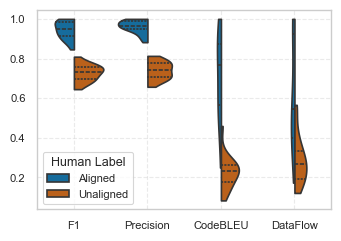

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Styling ---
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.0)  # Match paper text (≈9pt)

# Custom colorblind-friendly palette (Tableau)
cb_palette = ["#0072B2", "#D55E00"]  # Blue = Aligned, Orange = Unaligned

# Merge all data
combined_df = pd.concat(
    [
        codebert_human_good_df,
        codebert_human_bad_df,
        codebleu_human_good_df,
        codebleu_human_bad_df,
    ],
    ignore_index=True,
)

# Metric label map
metric_map = {
    "F1": "F1",
    "precision": "Precision",
    "codebleu": "CodeBLEU",
    "dataflow_match_score": "DataFlow",
}

# Melt and filter
melted_df = combined_df.melt(
    id_vars=["id", "Quality", "Source"],
    value_vars=list(metric_map.keys()),
    var_name="Metric",
    value_name="Score",
).dropna(subset=["Score"])

# Rename metric and quality labels
melted_df["Metric"] = melted_df["Metric"].map(metric_map)
melted_df["Quality"] = melted_df["Quality"].map({"Good": "Aligned", "Bad": "Unaligned"})

# Create figure sized for 1-column width (~3.5 in)
fig = plt.figure(figsize=(3.5, 2.5))

# Plot
sns.violinplot(
    data=melted_df,
    x="Metric",  # <--- rotated here
    y="Score",  # <--- now score is on the x-axis
    hue="Quality",
    split=True,
    inner="quartile",
    palette=cb_palette,
    cut=0,
    linewidth=1.2,
    # orient="v",  # horizontal orientation
)


# Axis + text styling
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("", fontsize=9)
plt.ylabel("", fontsize=9, labelpad=5)
plt.legend(title="Human Label", fontsize=8, title_fontsize=9)
plt.grid(True, linestyle="--", alpha=0.4)

# Save in high quality
plt.tight_layout()
# fig.savefig("validation_framework.pdf", dpi=300, bbox_inches="tight")
# fig.savefig("validation_framework.png", dpi=300, bbox_inches="tight")
# fig.savefig("validation_framework.svg", dpi=300, bbox_inches="tight")
plt.show()

### Table 1: AutoSketchEval – Statistical Results for Metric-Based Differentiation Between Aligned and Unaligned Samples.

In [4]:
from scipy.stats import mannwhitneyu, ks_2samp, chi2_contingency, levene, wilcoxon
from sklearn.metrics import roc_auc_score
from cliffs_delta import cliffs_delta
import numpy as np
import pandas as pd

# Container for results
stat_results = []


def bin_data(series, bins=10):
    return pd.cut(series, bins=bins, labels=False)


def p_with_stars(p):
    if pd.isna(p):
        return ""
    elif p < 0.01:
        return f"{p:.3f}***"
    elif p < 0.05:
        return f"{p:.3f}**"
    elif p < 0.1:
        return f"{p:.3f}*"
    else:
        return f"{p:.3f}"


def label_cliffs(delta):
    abs_delta = abs(delta)
    if abs_delta < 0.147:
        return f"{delta:.2f} (negligible)"
    elif abs_delta < 0.33:
        return f"{delta:.2f} (small)"
    elif abs_delta < 0.474:
        return f"{delta:.2f} (medium)"
    else:
        return f"{delta:.2f} (large)"


plots = {
    "CodeBERT": ["F1", "precision"],
    "CodeBLEU": ["codebleu", "dataflow_match_score"],
}

for source, metrics in plots.items():
    subset = combined_df[combined_df["Source"] == source]

    for metric in metrics:
        metric_data = subset[["id", "Quality", metric]].dropna()
        good = metric_data[metric_data["Quality"] == "Good"][metric]
        bad = metric_data[metric_data["Quality"] == "Bad"][metric]

        if len(good) > 5 and len(bad) > 5:
            try:
                _, mw_p = mannwhitneyu(good, bad, alternative="two-sided")
            except:
                mw_p = np.nan

            try:
                _, ks_p = ks_2samp(good, bad)
            except:
                ks_p = np.nan

            try:
                _, lev_p = levene(good, bad)
            except:
                lev_p = np.nan

            # AUC
            try:
                labels = [1] * len(good) + [0] * len(bad)
                scores = pd.concat([good, bad]).values
                auc = roc_auc_score(labels, scores)
                auc_str = f"{auc:.3f}"
            except:
                auc_str = ""

            # Cliff's Delta
            try:
                delta, _ = cliffs_delta(good.tolist(), bad.tolist())
                cliffs_str = label_cliffs(delta)
            except:
                cliffs_str = ""

            stat_results.append(
                {
                    "Source": source,
                    "Metric": metric,
                    "MannWhitneyU_p": p_with_stars(mw_p),
                    "KS_p": p_with_stars(ks_p),
                    "Levene_p": p_with_stars(lev_p),
                    "AUC": auc_str,
                    "Cliff's Delta": cliffs_str,
                }
            )

# Convert to DataFrame and print LaTeX
results_df = pd.DataFrame(stat_results)
print(results_df)

     Source                Metric MannWhitneyU_p      KS_p  Levene_p    AUC  \
0  CodeBERT                    F1       0.000***  0.000***     0.672  1.000   
1  CodeBERT             precision       0.000***  0.000***     0.113  1.000   
2  CodeBLEU              codebleu       0.000***  0.000***  0.000***  0.978   
3  CodeBLEU  dataflow_match_score       0.000***  0.000***  0.003***  0.871   

  Cliff's Delta  
0  1.00 (large)  
1  1.00 (large)  
2  0.96 (large)  
3  0.74 (large)  


## RQ2: Performance of Automatic Sketch Generators

In [6]:
# Paths
import pandas as pd

codebleu_single_df = pd.read_csv("ground_truth/codebleu_single.csv")
codebert_single_df = pd.read_csv("ground_truth/codebert_single.csv")
codebleu_multi_df = pd.read_csv("ground_truth/codebleu_multi.csv")
codebert_multi_df = pd.read_csv("ground_truth/codebert_multi.csv")
codebleu_baseline_df = pd.read_csv("ground_truth/codebleu_baseline.csv")
codebert_baseline_df = pd.read_csv("ground_truth/codebert_baseline.csv")

In [7]:
codebleu_single_df.columns = ["id", "codebleu", "ngram", "w_ngram", "syntax", "dataflow"]
codebleu_multi_df.columns = ["id", "codebleu", "ngram", "w_ngram", "syntax", "dataflow"]
codebleu_baseline_df.columns = ["id", "codebleu", "ngram", "w_ngram", "syntax", "dataflow"]

In [ ]:
codebert_single_df["group"] = "Single"
codebleu_single_df["group"] = "Single"

codebert_multi_df["group"] = "Multi"
codebleu_multi_df["group"] = "Multi"

codebleu_baseline_df["group"] = "Baseline"
codebert_baseline_df["group"] = "Baseline"

df_codebert = pd.concat([codebert_single_df, codebert_multi_df, codebert_baseline_df])
df_codebleu = pd.concat([codebleu_single_df, codebleu_multi_df, codebleu_baseline_df])


# df_score_judge = pd.concat([score_judge_single_df, score_judge_multi_df])

# Melt CodeBLEU
df_codebleu_melted = df_codebleu.melt(
    id_vars=["id", "group"],
    value_vars=["codebleu", "syntax", "dataflow"],
    var_name="metric",
    value_name="score",
    ignore_index=True,
)

# Melt CodeBERT
df_codebert_melted = df_codebert.melt(
    id_vars=["id", "group"],
    value_vars=["precision", "recall", "F1"],
    var_name="metric",
    value_name="score",
    ignore_index=True,
)
# Combine all
df_all = pd.concat([df_codebleu_melted, df_codebert_melted])

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter for only the two groups you want to compare
df_comp = df_all[df_all["group"].isin(["Multi", "Single"])]

# Pivot to get Multi and SingleAgent scores side by side
df_pivot = df_comp.pivot_table(
    index=["id", "metric"], columns="group", values="score"
).reset_index()

# Drop rows with missing data (e.g., one group is missing for a notebook)
df_pivot = df_pivot.dropna(subset=["Multi", "Single"])

# Compute Δᵢ = Multiᵢ − SingleAgentᵢ
df_pivot["delta"] = df_pivot["Multi"] - df_pivot["Single"]

# 2. % of notebooks where Multi > SingleAgent
pct_improved = (df_pivot["delta"] > 0).mean() * 100

# 3. Mean and standard deviation of Δ
mean_delta = df_pivot["delta"].mean()
std_delta = df_pivot["delta"].std()

# Print summary
print(f"📈 Multi-Agent better in {pct_improved:.2f}% of notebooks")
print(f"📊 Mean Δ: {mean_delta:.4f}")
print(f"📉 Std Dev of Δ: {std_delta:.4f}")

📈 Multi-Agent better in 56.94% of notebooks
📊 Mean Δ: 0.0014
📉 Std Dev of Δ: 0.0927


In [11]:
import pandas as pd

# Load CSV files
df_multi = pd.read_csv("processing_times_multi_agent.csv")
df_single = pd.read_csv("processing_times_single_agent.csv")

# Compute stats
mean_multi = df_multi["processing_time_seconds"].mean()
std_multi = df_multi["processing_time_seconds"].std()

mean_single = df_single["processing_time_seconds"].mean()
std_single = df_single["processing_time_seconds"].std()

print("=== Processing Time Comparison ===")
print(f"Multi-Agent - Mean: {mean_multi:.2f} s, Std Dev: {std_multi:.2f} s")
print(f"Single-Agent - Mean: {mean_single:.2f} s, Std Dev: {std_single:.2f} s")

# Compute how many times faster single is vs multi
if mean_multi > 0:
    times_faster = mean_multi / mean_single
    print(
        f"\nSingle-Agent is {times_faster:.2f} times faster than Multi-Agent on average."
    )
else:
    print("\nMean multi-agent time is zero or invalid, cannot compute speedup.")

=== Processing Time Comparison ===
Multi-Agent - Mean: 93.43 s, Std Dev: 29.24 s
Single-Agent - Mean: 8.27 s, Std Dev: 7.84 s

Single-Agent is 11.30 times faster than Multi-Agent on average.


### Table 2: Comparison of baseline and VisDocSketcher performance, reporting the 5th percentile and average values.

**NOTE:** Top-level columns (Metrics and Methods) are swaped in the paper. The table was modified in latex to facilitate comparison by metric. 

In [34]:
import pandas as pd

# Filter relevant groups
groups = ["Baseline", "Single", "Multi"]
df_filtered = df_all[df_all["group"].isin(groups)]

# Compute mean per group and metric
mean_stats = (
    df_filtered.groupby(["group", "metric"])["score"].mean().reset_index(name="mean")
)

# Compute 5th percentile per group and metric
percentile_5 = (
    df_filtered.groupby(["group", "metric"])["score"]
    .quantile(0.05)
    .reset_index(name="p05")
)

# Merge mean and p05 stats
stats = mean_stats.merge(percentile_5, on=["group", "metric"])

# Separate Baseline stats
baseline_stats = stats[stats["group"] == "Baseline"].set_index("metric")

# Compute Avg Multi+Single stats by averaging Single and Multi stats
multi_single_stats = stats[stats["group"].isin(["Multi", "Single"])]
avg_multi_single_stats = multi_single_stats.groupby("metric")[["mean", "p05"]].mean()

# Combine Baseline and Avg Multi+Single into one DataFrame with multi-level columns
combined_stats = pd.concat(
    {
        "Baseline": baseline_stats[["mean", "p05"]],
        "VisDocS": avg_multi_single_stats,
    },
    axis=1,
)

# Clean up column names
combined_stats.columns.names = ["Group", "Stat"]

# Format values nicely
combined_stats = combined_stats.applymap(lambda x: f"{x:.3f}")

combined_stats

/var/folders/cv/2tmgxdln49q85ppjm8wzrhww0000gr/T/ipykernel_33015/3011368911.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  combined_stats = combined_stats.applymap(lambda x: f"{x:.3f}")


Group     Baseline      VisDocS       
Stat          mean  p05    mean    p05
metric                                
F1             nan  nan   0.836  0.753
codebleu       nan  nan   0.333  0.177
dataflow       nan  nan   0.342  0.125
precision      nan  nan   0.863  0.784

### Figure 5: Distribution of Pairwise Differences Across Metrics.

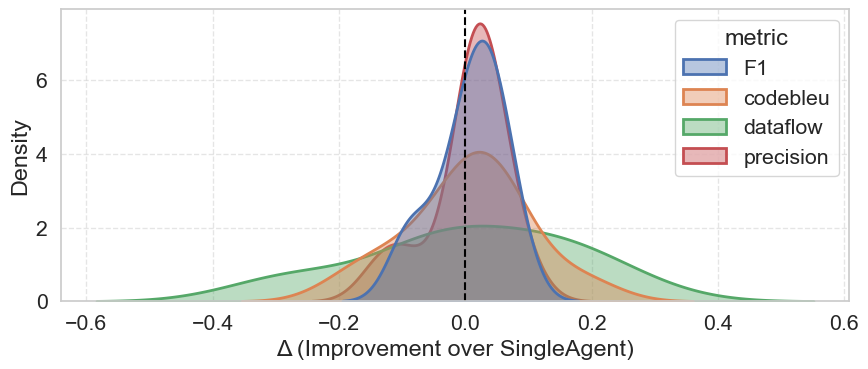

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt


codebert_single_df["group"] = "Single"
codebleu_single_df["group"] = "Single"

codebert_multi_df["group"] = "Multi"
codebleu_multi_df["group"] = "Multi"


df_codebert = pd.concat([codebert_single_df, codebert_multi_df])
df_codebleu = pd.concat([codebleu_single_df, codebleu_multi_df])

# Melt CodeBLEU
df_codebleu_melted = df_codebleu.melt(
    id_vars=["id", "group"],
    value_vars=["codebleu", "dataflow"],
    var_name="metric",
    value_name="score",
    ignore_index=True,
)

# Melt CodeBERT
df_codebert_melted = df_codebert.melt(
    id_vars=["id", "group"],
    value_vars=["precision", "F1"],
    var_name="metric",
    value_name="score",
    ignore_index=True,
)

df_all = pd.concat([df_codebleu_melted, df_codebert_melted])


# Prepare Δ per (id, metric)
df_comp = df_all[df_all["group"].isin(["Multi", "Single"])]
df_pivot = df_comp.pivot_table(
    index=["id", "metric"], columns="group", values="score"
).dropna()
df_pivot["delta"] = df_pivot["Multi"] - df_pivot["Single"]
df_pivot = df_pivot.reset_index()  # to plot with seaborn


# Improve overall font size
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.4)  # increase font sizes

# Plot overlapping KDEs
plt.figure(figsize=(9, 4))  # wider and more readable

sns.kdeplot(
    data=df_pivot,
    x="delta",
    hue="metric",
    fill=True,
    common_norm=False,
    alpha=0.4,
    linewidth=2,
)

plt.axvline(0, color="black", linestyle="--", label="Δ = 0")
plt.xlabel("Δ (Improvement over SingleAgent)")
plt.ylabel("Density")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
# plt.savefig("delta_distribution.pdf")
plt.show()

## RQ3: Impact of Notebook Complexity

### Table 3: Regression Results: Dataflow and Notebook Complexity.

In [50]:
codebleu_single_df = pd.read_csv("large_scale/codebleu_single.csv")
codebert_single_df = pd.read_csv("large_scale/codebert_single.csv")
codebleu_multi_df = pd.read_csv("large_scale/codebleu_multi.csv")
codebert_multi_df = pd.read_csv("large_scale/codebert_multi.csv")
notebook_features_df = pd.read_csv(
    "large_scale/notebook_features.csv"
)
notebook_features_df = notebook_features_df[
    ["kernel_id", "PT", "CC", "LOC"]
]

codebleu_single_df.columns = ["id", "codebleu", "ngram", "w_ngram", "syntax", "dataflow"]
codebleu_multi_df.columns = ["id", "codebleu", "ngram", "w_ngram", "syntax", "dataflow"]
notebook_features_df.columns = ["kernel_id", "PT", "CC", "LOC"]

In [51]:
codebert_single_df["group"] = "Single"
codebleu_single_df["group"] = "Single"

codebert_multi_df["group"] = "Multi"
codebleu_multi_df["group"] = "Multi"


df_codebert = pd.concat([codebert_single_df, codebert_multi_df])
df_codebleu = pd.concat([codebleu_single_df, codebleu_multi_df])

# Melt CodeBLEU
df_codebleu_melted = df_codebleu.melt(
    id_vars=["id", "group"],
    value_vars=["codebleu", "syntax", "dataflow"],
    var_name="metric",
    value_name="score",
    ignore_index=True,
)

# Melt CodeBERT
df_codebert_melted = df_codebert.melt(
    id_vars=["id", "group"],
    value_vars=["precision", "recall", "F1", "F3"],
    var_name="metric",
    value_name="score",
    ignore_index=True,
)


# Combine all
df_all = pd.concat([df_codebleu_melted, df_codebert_melted])

In [52]:
# Add a "condition" column to distinguish the source
codebleu_single_df["condition"] = "single"
codebleu_multi_df["condition"] = "multi"

# Combine the two
combined_df = pd.concat([codebleu_single_df, codebleu_multi_df], ignore_index=True)

# Merge with notebook features (e.g., LOC, PT, NVD)
merged_df = combined_df.merge(notebook_features_df, left_on="id", right_on="kernel_id")

In [53]:
import statsmodels.formula.api as smf
import pandas as pd

# Convert to categorical
merged_df["condition"] = merged_df["condition"].astype("category")
merged_df["condition"] = merged_df["condition"].cat.reorder_categories(
    ["single", "multi"], ordered=True
)

merged_df["PT"] = merged_df["PT"].astype("category")
# merged_df["NVD"] = merged_df["NVD"].astype("category")


def print_significance(model, title="Model Summary"):
    summary_df = model.summary2().tables[1]  # Coefficients table

    # Add significance stars
    summary_df["significance"] = summary_df["P>|t|"].apply(
        lambda p: "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
    )

    # Print title and coefficients with stars
    print(f"\n=== {title} ===")
    print(summary_df[["Coef.", "Std.Err.", "t", "P>|t|", "significance"]])

    # Print R² and Adjusted R²
    print(f"\nR² = {model.rsquared:.4f}")
    print(f"Adjusted R² = {model.rsquared_adj:.4f}")


# (A) General regression
model_general = smf.ols("dataflow ~ LOC + CC + PT", data=merged_df).fit()
print_significance(model_general, "General Model")

# (B) Interaction regression
model_interaction = smf.ols(
    "dataflow ~ LOC * condition + CC * condition + PT * condition",
    data=merged_df,
).fit()
print_significance(model_interaction, "Interaction Model")


=== General Model ===
              Coef.  Std.Err.          t          P>|t| significance
Intercept  0.265367  0.008349  31.782657  3.796261e-168          ***
PT[T.1]   -0.007443  0.009372  -0.794184   4.272202e-01             
PT[T.2]   -0.016703  0.008527  -1.958933   5.031477e-02             
PT[T.3]   -0.014572  0.010375  -1.404575   1.603648e-01             
PT[T.4]    0.016113  0.012527   1.286283   1.985526e-01             
PT[T.5]   -0.150025  0.010329 -14.524469   1.090877e-44          ***
LOC       -0.000807  0.000042 -19.062608   2.283995e-72          ***
CC        -0.001158  0.000291  -3.972349   7.471038e-05          ***

R² = 0.3535
Adjusted R² = 0.3504

=== Interaction Model ===
                               Coef.  Std.Err.          t          P>|t|  \
Intercept                   0.268837  0.010742  25.027670  7.587456e-115   
condition[T.multi]         -0.007435  0.016834  -0.441687   6.587830e-01   
PT[T.1]                     0.004146  0.012276   0.337710   7.35631